# Interacting with OSM Data

Importing packages

In [4]:
from shapely.geometry import Point, LineString
import numpy as np
import rasterio
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
import xml.etree.ElementTree as ET
import gpxpy.gpx
from pyproj import CRS
from pyproj import Transformer

### Importing the data
Background

In [5]:
raster_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_South+Dartmoor_2004150', 'raster-25k_4541337', 'sx', 'sx56.tif'))

Network_data

In [6]:
road_links = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_roads_Dartmoor_link.geojson'))
road_links = road_links.to_crs(27700)

road_nodes = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_roads_Dartmoor_node.geojson'))
road_nodes = road_nodes.to_crs(27700)

path_links = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_track_Dartmoor_link.geojson'))
path_links = path_links.to_crs(27700)

path_nodes = gpd.read_file(os.path.join('OpenStreetMap', 'Dartmoor','highway_track_Dartmoor_node.geojson'))
path_nodes = path_nodes.to_crs(27700)

In [7]:
path_links

,full_id,osm_id,osm_type,highway,bicycle,segregated,foot,intermittent,tactile_paving,footway,...,bridge,cycleway,prow_ref,motor_vehicle,horse,designation,access,surface,name,geometry
0,w5182875,5182875,way,cycleway,designated,None,None,None,None,None,...,None,None,None,None,None,None,None,paved,Granite Way,"LINESTRING (258753.214 94249.395, 258753.062 9..."
1,w12897169,12897169,way,bridleway,None,None,designated,None,None,None,...,None,None,Manaton Bridleway 9,no,designated,public_bridleway,yes,None,None,"LINESTRING (273246.456 79907.984, 273222.381 7..."
2,w13038733,13038733,way,bridleway,None,None,None,None,None,None,...,None,None,None,None,None,public_bridleway,None,None,None,"LINESTRING (272100.504 80198.981, 272095.153 8..."
3,w13044464,13044464,way,track,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (267450.547 78664.234, 267459.846 7..."
4,w13044472,13044472,way,track,None,None,None,None,None,None,...,None,None,None,None,None,None,None,gravel,None,"LINESTRING (266769.359 73526.397, 266745.033 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5699,w1066238478,1066238478,way,path,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (255364.213 75058.370, 255364.105 7..."
5700,w1066238479,1066238479,way,path,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (255362.980 75192.150, 255364.543 7..."
5701,w1066238480,1066238480,way,path,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,"LINESTRING (255363.090 75258.631, 255372.348 7..."
5702,w1067621517,1067621517,way,track,permissive,None,yes,None,None,None,...,None,None,None,no,permissive,None,None,earth,Upper Deer Stalkers Path,"LINESTRING (274326.542 89229.159, 274266.013 8..."


<AxesSubplot:>

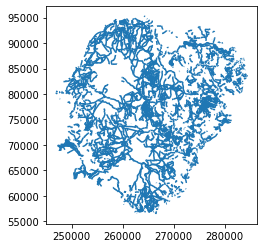

In [8]:
path_links.plot()

<AxesSubplot:>

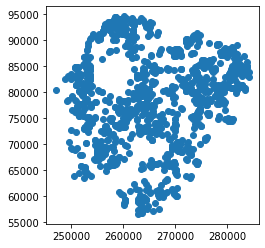

In [9]:
path_nodes.plot()

Plotting in the raster map

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:18: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


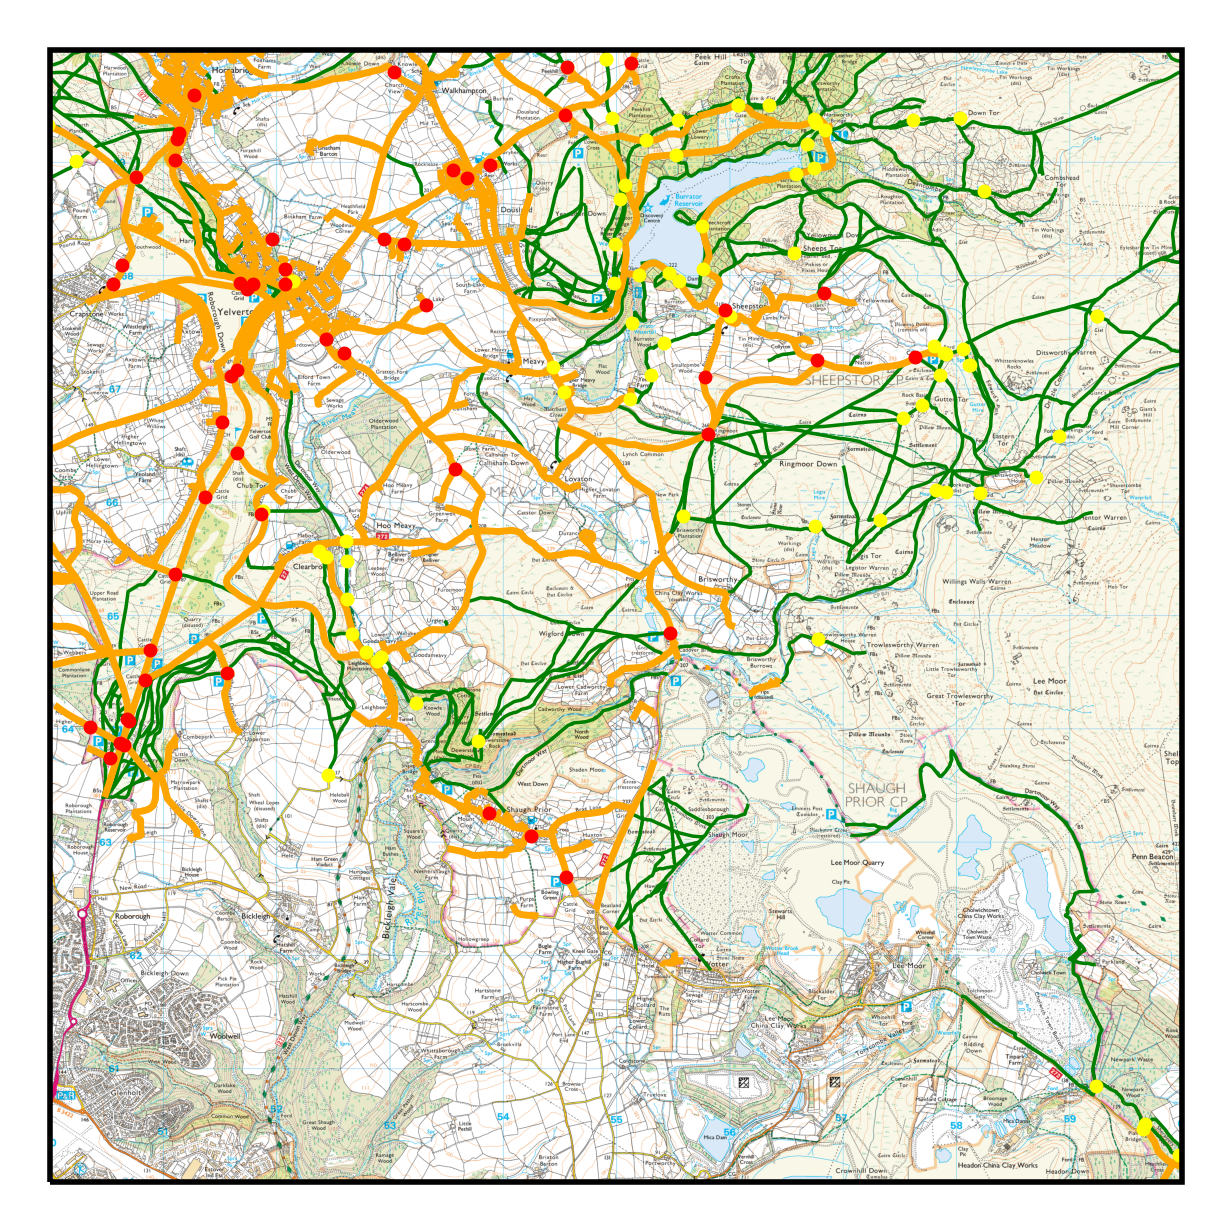

In [10]:
back_array = raster_map.read(1)
palette = np.array([value for key, value in raster_map.colormap(1).items()])
background_image = palette[back_array]
bounds = raster_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)
fig = plt.figure(figsize=(3, 3), dpi=500)

ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

path_links.plot(ax=ax, edgecolor='green', linewidth=0.5, zorder=1)
path_nodes.plot(ax=ax, color='yellow', markersize=1, zorder=2)

road_links.plot(ax=ax, edgecolor='orange', linewidth=1, zorder=1)
road_nodes.plot(ax=ax, color='red', markersize=1, zorder=2)

display_extent = extent
ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()

Merging links

<AxesSubplot:>

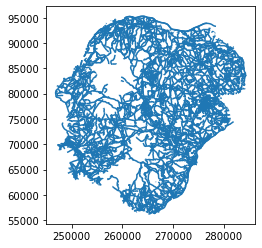

In [11]:
path_geom = [path for path in path_links['geometry']]
road_geom = [road for road in road_links['geometry']]
geom = path_geom + road_geom

path_ids = [id for id in path_links['full_id']]
road_ids = [id for id in road_links['full_id']]
ids = path_ids + road_ids

Dartmoor_links = gpd.GeoDataFrame({'fid': ids, 'geometry': geom})
Dartmoor_links.plot()

Creating an index using links

In [19]:
idx = index.Index()

for i in range(len(Dartmoor_links['fid'])):
    left, bottom, right, top = (Dartmoor_links['geometry'][i].bounds[0], Dartmoor_links['geometry'][i].bounds[1],
                                    Dartmoor_links['geometry'][i].bounds[2], Dartmoor_links['geometry'][i].bounds[3])
    idx.insert(i, (left, bottom, right, top))